## Intro 1: Interface evolution, repopulation and smoothing

* interface2D objects are advected using the standard parallel swarm advecting routines
* UW2 does handle the density of 1D objects, so we inroduce some functionailiy for doing that

In [1]:
#use this block to point to a local version of UWsubduction
import sys

try:
    sys.path.append('..')
except:
    pass

In [2]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator
import UWsubduction as usub

In [11]:
minX = -1.0
maxX = 1.0
resX = 48
resY = 24
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, -0.5), 
                                 maxCoord    = ( maxX, 0.5),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [12]:
coordinate = fn.input()
yFn = coordinate[1]

In [13]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [14]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [15]:
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

markerXs = np.linspace(-0.8, 0.8, 40)
markerYs = np.linspace(-0.4, 0.4, 40)


markerThickness = 0.1

line1 = interface2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))

line2 = interface2D(mesh, velocityField, markerXs, -1.*markerYs, 
                        markerThickness, 2, insidePt=(0.,-10.))

## Healing

In [23]:
from unsupported_dan.interfaces.smoothing2D import *

In [24]:
np.unique(line1.swarm.particleCoordinates.data[:,0]).shape

(40,)

In [25]:
#line1.rebuild()
out = shadowMask(line1)


In [26]:
ds = 1.6/40.
A = line1.neighbourMatrix(k =4, jitter=1e-8)
midPoints, currentIds = neighbourDistanceQuery(line1, A, _lowdist=0.,_updist= 5.5*ds)

In [27]:
currentIds

array([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,
        8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16,
       18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26,
       25, 27, 26, 28, 27, 29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 34, 33,
       35, 34, 36, 35, 37, 36, 38, 37])

In [28]:
#apcs = line1.all_coords()
#apcs

In [29]:
#line1.data

## Tests for small data

In [10]:
%load_ext autoreload
from unsupported_dan.interfaces.smoothing2D import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
fib = lambda n: n if n < 2 else fib(n-1) + fib(n-2)

for i in range(1, 15):
    
    i = fib(i)
    
    testLine = markerLine2D(mesh, velocityField, markerXs[:i], markerYs[:i], 
                        markerThickness, 1, insidePt=(0.,-10.))
    print(i)
    ### basic matrices: methods of markerLine2D
    
    a = testLine.neighbourMatrix()
    L = testLine.laplacianMatrix(k = 8)
    pd = testLine.pairDistanceMatrix()
    
    ### accessory routines: bits of functions from healing2d
    l = laplaceVector(testLine, k = 8, limit=0.25)
    ndq = neighbourDistanceQuery(testLine, a, _lowdist=1e-10, _updist = False)
    mask = np.where(a.sum(axis=1) != 2)
    sm = shadowMask(testLine)
    pt = particlesToAdd(testLine, a, _lowdist=0.0001, _updist = False)
    

1
1
2
3
5
8
13
21
34
55
89
144
233
377


Populating the interactive namespace from numpy and matplotlib


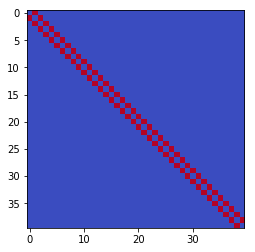

In [16]:
%pylab inline
plt.imshow(a, cmap='coolwarm')

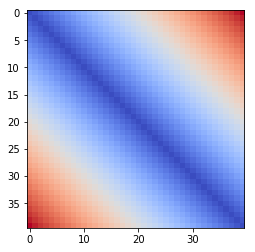

In [17]:
plt.imshow(pd, cmap='coolwarm')

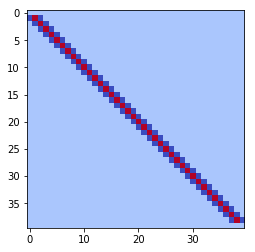

In [18]:
plt.imshow(L, cmap='coolwarm')

## Scratch

In [30]:
test = np.arange(10)
testMask = np.random.randint(0,2,9).astype('bool')
#testMask.astype('bool')

In [32]:
out = test[testMask]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 9
  if __name__ == '__main__':


In [33]:
out

array([1, 2, 3, 4, 8])

NameError: name 'line1' is not defined